In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import pickle
from lmfit.models import LinearModel, LorentzianModel

In [34]:
folder = r"Z:\P110143-phosphosulfides-Andrea\Data\Samples\mittma_0019_Cu\Raman\BR"
files = os.listdir(folder)
files = [f for f in files if f.endswith('.txt')]
print(files)
all_results = {}

['mittma_0019_BR_5perc_5sx5aq bl.txt', 'mittma_0019_BR_5perc_5sx5aq br.txt', 'mittma_0019_BR_5perc_5sx5aq tc-1mm.txt', 'mittma_0019_BR_5perc_5sx5aq tc.txt', 'mittma_0019_BR_5perc_5sx5aq tl.txt', 'mittma_0019_BR_5perc_5sx5aq tr-2mm.txt', 'mittma_0019_BR_5perc_5sx5aq tr.txt', 'mittma_0019_BR_raman_fit.txt']


In [35]:
samples_to_analyse = ['bl', 'br', 'tc', 'tc-1mm', 'tl', 'tr', 'tr-2mm']
sample_name= 'mittma_0019_BR'
filename= sample_name + '_5perc_5sx5aq '

,wavenumber,intensity
1014,-172.794922,7.058754
1013,-171.378906,3.530122
1012,-169.962891,22.950632
1011,-168.546875,-10.594833
1010,-167.130859,15.895601
...,...,...
4,1123.490234,2117.299072
3,1124.654297,2081.165283
2,1125.818359,2158.869141
1,1126.982422,2146.363281


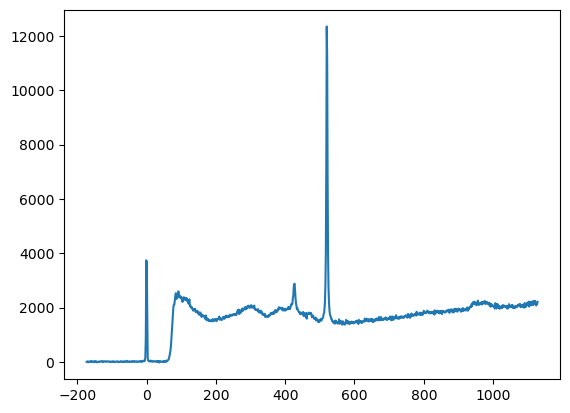

In [80]:
n=2
filepath= os.path.join(folder, filename + f'{samples_to_analyse[n]}.txt')
data = pd.read_csv(filepath, sep='\t', skiprows=1, names=['wavenumber', 'intensity'])

data.sort_values('wavenumber', inplace=True)
display(data)
plt.plot(data['wavenumber'], data['intensity'])

[ 76 172 244]


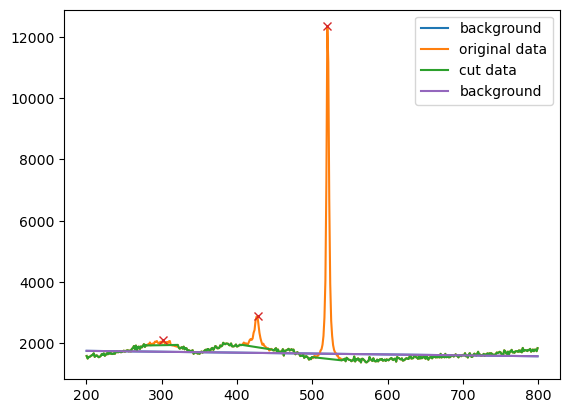

In [81]:
# select wavenumber range
data_cut = data[(data['wavenumber'] > 200) & (data['wavenumber'] < 800)]
x0= data_cut['wavenumber']
y0= data_cut['intensity']
#find peaks in the data
from scipy.signal import find_peaks

initial_peaks, _ = find_peaks(y0, prominence=300, width=2)
print(initial_peaks)
y_cut= y0.copy()

for peak in initial_peaks: 
    start_index = max(0, peak-15)
    end_index = min(len(y0), peak+15)
    y_cut[start_index:end_index] = np.nan

mask = ~np.isnan(y_cut)
x_cut = x0[mask]
y_cut = y0[mask]

#calculate background
bkg_coeffs = np.polyfit(x_cut, y_cut, 1)
bkg = np.polyval(bkg_coeffs, x0)
plt.plot(x0, bkg, label='background')

plt.plot(x0, y0, label='original data')
plt.plot(x_cut, y_cut, label='cut data')
plt.plot(x0.iloc[initial_peaks], y0.iloc[initial_peaks], "x")
plt.plot(x0, bkg, label='background')
plt.legend()


[ 76 172 204 244]
0.0


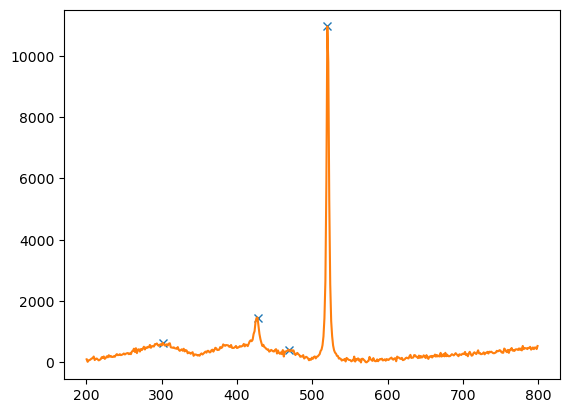

In [82]:
x= x0
yy= y0 - bkg
min_y= min(yy)
y= yy - min_y
peaks, _ = find_peaks(y, prominence=200, width=2)
print(peaks)
plt.plot(x.iloc[peaks], y.iloc[peaks], "x")
plt.plot(x, y)
print(min(y))


##### fit individual peaks

520.4285990700646 64553.528541956635 3.4613784802468164


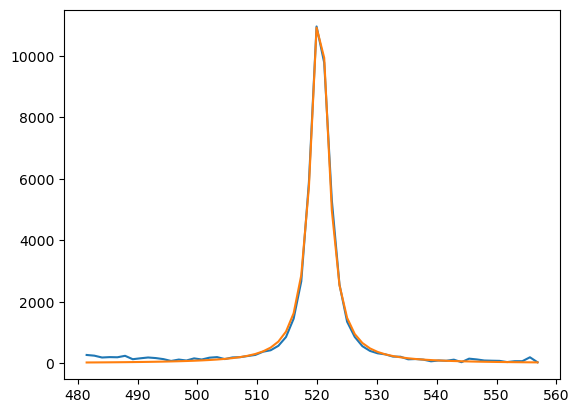

In [83]:
peak_1= peaks[-1]
x_1,y_1 = x[peak_1-30:peak_1+30], y[peak_1-30:peak_1+30]
x_1.reset_index(drop=True, inplace=True)
y_1.reset_index(drop=True, inplace=True)

model= LorentzianModel(prefix='peak_')
pars = model.guess(y_1, x=x_1)
out = model.fit(y_1, pars, x=x_1)
# print(out.fit_report())
center = out.params['peak_center'].value
amplitude = out.params['peak_amplitude'].value
fwhm = out.params['peak_fwhm'].value

plt.plot(x_1, y_1)
plt.plot(x_1, out.best_fit)
print(center, amplitude, fwhm)

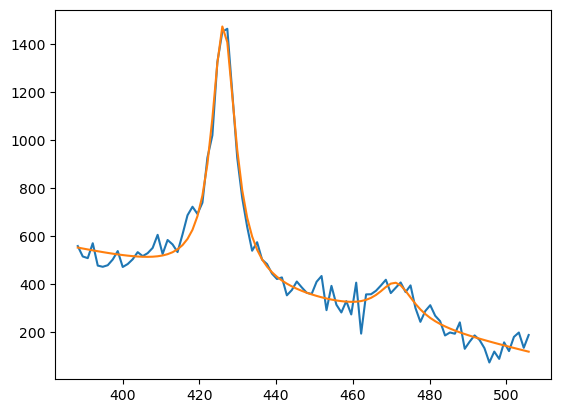

In [84]:
# fit peaks 1, 2 with 2 lorentianz

x_1,y_1 = x[peaks[1]-30:peaks[2]+30], y[peaks[1]-30:peaks[2]+30]
x_1.reset_index(drop=True, inplace=True)
y_1.reset_index(drop=True, inplace=True)

back = LinearModel(prefix='back_')
model1= LorentzianModel(prefix='peak1_')
model2= LorentzianModel(prefix='peak2_')

pars = back.guess(y_1, x=x_1)
pars1 = model1.guess(y_1, x=x_1)
pars2 = model2.guess(y_1, x=x_1)
pars1.update(pars2)
pars1.update(pars)
pars1['peak1_center'].set(value= x.iloc[peaks[1]])
pars1['peak2_center'].set(value= x.iloc[peaks[2]]) #, vary=False)
combined_model = back + model1 + model2
out = combined_model.fit(y_1, pars1, x=x_1)

plt.plot(x_1, y_1)
plt.plot(x_1, out.best_fit)

##### fit all

0
1
2
3


{'peak_0': (301.720703, 9793.432669815142, 26.039717280817182),
 'peak_1': (427.28125, 27873.246238548058, 18.552733234949113),
 'peak_2': (468.611328, 4351.9808503348795, 12.866984604590291),
 'peak_3': (519.916016, 63945.20393072079, 3.657198168814621)}

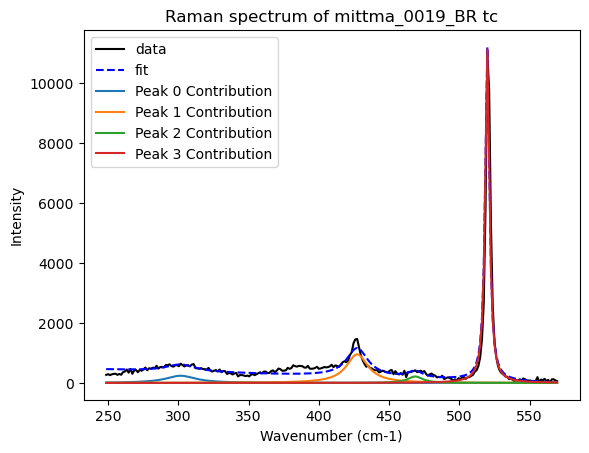

In [97]:
# try to fit all peaks with lorentzian at the same time

x_all, y_all = x[peaks[0]-40:peaks[-1]+40], y[peaks[0]-40:peaks[-1]+40]
x_all.reset_index(drop=True, inplace=True)
y_all.reset_index(drop=True, inplace=True)

back = LinearModel(prefix='back_')
pars = back.guess(y_all, x=x_all)
models= {}
params = {}
for i in range(len(peaks)):
    print(i)
    models[i]= LorentzianModel(prefix=f'peak{i}_')
    params[f'peak_{i}'] = models[i].guess(y_all, x=x_all)
    pars.update(params[f'peak_{i}'])
    # print(pars)
    pars[f'peak{i}_center'].set(value= x.iloc[peaks[i]], vary=False)
    pars[f'peak{i}_amplitude'].set(value= y.iloc[peaks[i]], min=0)
    pars[f'peak{i}_fwhm'].set(value= 10, min=0)
    pars[f'peak{i}_height'].set(value= 10, min=0)
    
    # pars[f'peak{i}_sigma'].set(value= 10)
    back += models[i]

out = back.fit(y_all, pars, x=x_all)
# print(out.fit_report())
plt.plot(x_all, y_all, 'k', label='data')
plt.plot(x_all, out.best_fit , 'b--',label='fit')

# Extract the individual peak parameters to plot them separately
results= {}
for i in range(len(peaks)):
    center= out.params[f'peak{i}_center'].value
    amplitude= out.params[f'peak{i}_amplitude'].value
    fwhm= 2*out.params[f'peak{i}_sigma'].value
    results[f'peak_{i}']= (center, amplitude, fwhm)

    peak = models[i].eval(params=out.params, x=x_all)
    plt.plot(x_all, peak, label=f'Peak {i} Contribution')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.title(f'Raman spectrum of {sample_name} {samples_to_analyse[n]}')
plt.legend()

plt.savefig(os.path.join(folder, f'{sample_name}_{samples_to_analyse[n]}_raman_fit.png'), dpi=300)
display(results)
plt.show()

In [98]:
#save theresult to a PD dataframe
df = pd.DataFrame(results).T
df.columns = ['center', 'amplitude', 'fwhm']


all_results[samples_to_analyse[n]] = df
display(all_results)

{'br':             center      amplitude       fwhm
 peak_0  307.000000   28320.973045  48.175514
 peak_1  388.296875   43576.062768  35.184016
 peak_2  425.984375   34191.316865  15.333950
 peak_3  471.187500   27955.690185  19.422937
 peak_4  519.916016  169970.767036   3.471029,
 'bl':             center      amplitude       fwhm
 peak_0  304.361328   19054.018455  29.926906
 peak_1  388.296875   34370.269980  37.470298
 peak_2  425.984375   34255.173352  10.937196
 peak_3  519.916016  227566.186061   3.696064,
 'tc':             center     amplitude       fwhm
 peak_0  301.720703   9793.432670  26.039717
 peak_1  427.281250  27873.246239  18.552733
 peak_2  468.611328   4351.980850  12.866985
 peak_3  519.916016  63945.203931   3.657198}